In [2]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st
from scipy.interpolate import interp1d

rez=600

#upload and interpolate Robb VL data
robb_boxes=pd.read_csv('data/Robb et al SI region%2Fclade VL characteristics - Sheet2 (1).csv')

robb=pd.read_csv('data/robb_ranges.csv',names=['logVL','days']); robbHI=robb[:15]; robbLO=robb[15:]
interpLO=interp1d(robbLO.days,robbLO.logVL); interpHI=interp1d(robbHI.days,robbHI.logVL)


In [23]:
#HIV model (don't need Abs yet)
def model(X,t,aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g):
    
    dY = np.zeros(8);

    S=X[0]; I=X[1]; AU=X[2]; AP=X[3]; LU=X[4]; LP=X[5]; E=X[6]; V=X[7];    
        
    phi=1
    
    dY[0] = aS - dS*S - Bt0*S*V                         #susceptible cells
    dY[1] = Bt0*S*V - phi*I    #active unproductively infected
    dY[2] = (1-tau)*(1-lam)*phi*I - dI*AU - k*E*AU + xi*LU    #active unproductively infected
    dY[3] = tau*(1-lam)*phi*I - dI*AP - k*E*AP + xi*LP        #active productively infected
    dY[4] = (1-tau)*lam*Bt0*S*V + thL*LU                #latent unproductively infected
    dY[5] = tau*lam*Bt0*S*V + thL*LP                    #latent productively infected
    dY[6] = w*E*(AP+AU)/(E+E50) + aE - dE*E;           #adaptive immune system
    dY[7] = p*AP - g*V - Bt0*S*V                        #virus
    return dY

def run_model(tt,X0,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g):
    
    infpoz,maxpoz,t_fp,t_max=0,0,0,0 #initialize a few variables
    
    sol=spi.odeint(model, X0, tt, (aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g), mxstep=10000) #solve model

    vll=np.log10(sol[:,7]/vol*1e3) #viral load as usual units copies/mL
    
    if (vll>-10).all() & (vll>2).any():        
        infpoz=np.where(vll>2)[0][0] #index of first positive
        maxpoz=np.where(vll==max(vll))[0][0]
        t_fp=tt[infpoz]
        t_max=tt[maxpoz]
    
    return sol,vll,infpoz,t_fp,t_max


2.5359782608695656


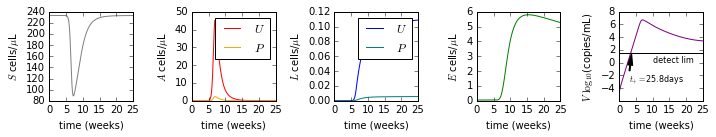

In [24]:
# parameters for viral dynamics model
vol = 1      # volume of blood [uL]
aS  = 70*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1.0       # active death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.05      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 0.3/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250*vol;   #50 pct max E cell concentration [cells/uL]*[uL]

R0=aS*Bt0*tau*(1-lam)*p/g/dS/dA; print(R0) # basic reproductive number

V0=1e-6 #start with 1 virion in body!

X0=np.array([aS/dS,0,0,0,0,0,aE/dE,V0])

t=np.linspace(0,25*7,1e4) #25 weeks

sol,vll,infpoz,t_fp,t_max=run_model(t,X0,aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g) 

fig,axarr=plt.subplots(1,5,figsize=(10,2),dpi=rez,sharex=True)
    
axarr[0].plot(t/7,sol[:,0],'gray')
axarr[0].set_ylabel('$S$ cells/$\mu$L')
axarr[0].set_xticks(range(0,26,5))
#axarr[0].set_xlim([0,8])

axarr[1].plot(t/7,sol[:,2],'red')
axarr[1].plot(t/7,sol[:,3],'orange')
axarr[1].set_ylabel('$A$ cells/$\mu$L')
axarr[1].legend(['$U$','$P$'])

axarr[2].plot(t/7,sol[:,4],'blue')
axarr[2].plot(t/7,sol[:,5],'teal')
axarr[2].set_ylabel('$L$ cells/$\mu$L')
axarr[2].legend(['$U$','$P$'])

axarr[3].plot(t/7,sol[:,6],'green')
axarr[3].set_ylabel('$E$ cells/$\mu$L')

axarr[4].plot(t/7,vll,'purple')
axarr[4].axhline(np.log10(30),color='k')
#axarr[4].axvline(t_fp/7,ls='--',color='k',lw=0.5)
axarr[4].annotate('detect lim',xy=[10,0],fontsize=8)
axarr[4].annotate('$t_{+}=$'+str(round(t_fp,1))+'days',fontsize=8,xy=(t_fp/7, np.log10(30)), 
                  xytext=(3, -3),arrowprops=dict(color='black',width=1, headwidth=5,shrink=10))
axarr[4].set_ylabel('$V$ $\log_{10}$(copies/mL)')
axarr[4].set_yticks(range(-4,9,2))

for i in range(5):
    axarr[i].set_xlabel('time (weeks)')
        
plt.tight_layout()
plt.savefig('figures/det_model.pdf')


In [25]:
#example of score of model
region='Africa'
def score_model(t,vll):

    d=robb_boxes[robb_boxes['Region']==region]
    
    ind_peak=np.argmax(vll) #index of peak viral load
    ind_nadir=np.argmin(vll[ind_peak:]) #index of nadir viral load

    #ind_setpoint=np.argwhere(t>84)[0][0] #day 80 should be at setpoint, 12 weeks
    #print(t[0])
    
    #list of statistics
    m_stats=np.array([
                vll[ind_peak], #peak VL
                t[ind_peak], #peak time
                vll[ind_nadir], #nadir VL
                t[ind_nadir], #nadir time
                vll[-1], #setpoint VL
                (vll[ind_peak]-vll[0])/(t[ind_peak]-t[0]), #upslope
                (vll[ind_nadir]-vll[ind_peak])/(t[ind_nadir]-t[ind_peak]) #downslope
                    ]) 

    ind_tofit = [0,1,2,3,4,6,7]

    #score the model
    totL=1
    for i in range(len(ind_tofit)):

        mu = d['mean'].iloc[ind_tofit[i]]
        sd = (d['Q2'].iloc[ind_tofit[i]]-d['Q1'].iloc[ind_tofit[i]])/1.35

        L = st.norm(mu,sd).pdf(m_stats[i])

        totL*=L
        
    return totL
    


In [26]:
#now see which parameter ranges fit in here
pnames_unix=['aS','dS','Bt0','tau','lam','dA','thL','xi','k','aE','dE','E50','w','p','g']
pvarlist=[      1,   1,    2,    1,    1,0.01,    1,   3,  1, 0.1,   1,    1,  1,  1, 0.1 ]

#for now and later, the time series and initial guess parameters
tt=np.linspace(0,100,1e4)
guessP=np.array([aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g])

sampz=10**3

goodP_list=[]; score=[]

bdz=1.#extra bounds for fitting shaded area

fposT=7

for i in range(sampz):
    ran_list=np.random.lognormal(np.zeros(len(pvarlist)),pvarlist,[len(pvarlist)])*guessP
    aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr=ran_list

    if aSr*Bt0r*taur*(1-lamr)*pr/gr/dSr/dAr<20: # basic reproductive number

        sol,vll,infpoz,t_fp,t_max=run_model(tt,X0,aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr)

        if (vll>-10).all() & (vll>2).any():        

            t_shifted = tt[infpoz:]-tt[infpoz]

            loV,hiV = interpLO(t_shifted),interpHI(t_shifted) #the bounds

            #first positive must be before 3 weeks and t_max must be after 3 days since first positive
            if (t_fp<21.) & (t_max-t_fp>3.):

                if ~ ((vll[infpoz:]>hiV*bdz).any() | (vll[infpoz:]<loV/bdz).any()):
                    goodP_list.append([aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr])#,x0r])

                    score.append(score_model(tt,vll))
                    
                    #plt.plot(tt[infpoz:],vll[infpoz:])

#make a csv with values of goodP
gf=pd.DataFrame(goodP_list,columns=pnames_unix)
pd.DataFrame.to_csv(gf,'goodP_list'+region+'.csv')


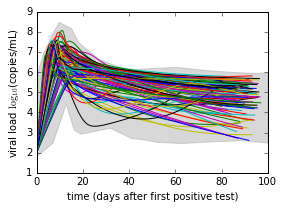

In [27]:
#plot all good list examples
plt.figure(figsize=(4,3),dpi=rez)

loV,hiV = interpLO(tt),interpHI(tt) #the bounds
for i in range(len(goodP_list)):
    aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr=goodP_list[i]

    sol,vll,infpoz,t_fp,t_max=run_model(
        tt,X0,aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr)

    plt.plot(tt[infpoz:]-tt[infpoz],vll[infpoz:])#,color='k',alpha=0.5) #zero out by first positive

plt.fill_between(tt, loV, hiV, color='gray',alpha=0.3)
plt.xlabel('time (days after first positive test)')
plt.ylabel('viral load $\log_{10}$(copies/mL)')
plt.tight_layout()
plt.savefig('figures/robb_examples.pdf')

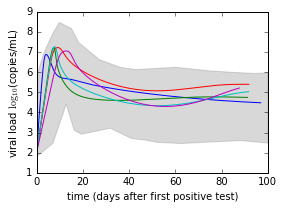

In [29]:
#plot top examples
plt.figure(figsize=(4,3),dpi=rez)

for i in range(5):
    aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr=goodP_list[np.argsort(np.log10(score))[-i]]

    sol,vll,infpoz,t_fp,t_max=run_model(
        tt,X0,aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr)

    #plt.plot(tt,vll)#,color='k',alpha=0.5) #zero out by first positive
    plt.plot(tt[infpoz:]-tt[infpoz],vll[infpoz:])#,color='k',alpha=0.5) #zero out by first positive

plt.fill_between(tt, loV, hiV, color='gray',alpha=0.3)
plt.xlabel('time (days after first positive test)')
plt.ylabel('viral load $\log_{10}$(copies/mL)')
plt.tight_layout()
plt.savefig('figures/robb_examples_best.pdf')

In [ ]:
#find the best fit?

def optimize_model(tt,X0,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g):
    
    aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr=np.random.lognormal(0,3,[15])*guessP

    if aSr*Bt0r*taur*(1-lamr)*pr/gr/dSr/dAr<10: # basic reproductive number

        sol,vll,infpoz,t_fp,t_max=run_model(tt,X0,aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr)

        if (vll>-10).all() & (vll>2).any():        

            t_shifted = tt[infpoz:]-tt[infpoz]

            loV,hiV = interpLO(t_shifted),interpHI(t_shifted) #the bounds

            #first positive must be before 3 weeks and t_max must be after 3 days since first positive
            if (t_fp<21.) & (t_max-t_fp>3.):

                if ~ ((vll[infpoz:]>hiV*bdz).any() | (vll[infpoz:]<loV/bdz).any()):
                    goodP_list.append([aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr])#,x0r])

                    score.append(score_model(t_shifted,vll))


In [ ]:
pnames_unix=['aS','dS','Bt0','tau','lam','dA','thL','xi','k','aE','dE','E50','w','p','g']

pnames=[r'$\alpha_S$',r'$\delta_S$',r'$\beta_0$',r'$\tau$',r'$\lambda$',
        r'$\delta_I$',r'$\theta_L$',r'$\xi$',r'$\kappa$',r'$\alpha_E$',
        r'$\delta_E$',r'$E_{50}$',r'$\omega$',r'$\pi$',r'$\gamma$']
        
fig,axarr=plt.subplots(5,3,sharey=False,figsize=(4,6),dpi=rez)
for j in range(15):
    ax=axarr[int(j/3.)][j%3]
    
    logpz=np.log10(np.array(goodP_list))
    
    #ax.violinplot(np.array(goodP_list)[:,j])#/guessP[j])
    ax.scatter(np.random.normal(1,0.02,len(goodP_list)),logpz[:,j],s=200/-np.log10(score),color='blue',alpha=0.7)#/guessP[j])
    ax.boxplot(logpz[:,j])#/guessP[j])
    ax.set_xlabel(pnames[j])
    ax.set_xticks([])
    ax.set_xlim([0.8,1.2])
    ax.set_yticks(range(int(np.min(logpz[:,j])),int(np.max(logpz[:,j])+1),1))
    #ax.set_yscale('log')
#axarr[1][0].set_ylabel('deviation from \n median value')
plt.tight_layout()
plt.savefig('figures/robb_fitparams.pdf')

In [ ]:
#make box plots of a few variable combos of interest

plt.figure(figsize=(6,2),dpi=rez)
plt.subplot(141)
plt.boxplot(np.log10(gf.aS/gf.dS))
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'initial susceptible cells ($\alpha_S/\delta_S$)',fontsize=8)
#plt.xticks([1],[r'$\alpha_S/\delta_S$'])
plt.legend(['log10'],loc=1,fontsize=8)

plt.subplot(142)
plt.boxplot(np.log10(gf.aE/gf.dE))
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'initial adaptive cells ($\alpha_E/\delta_E$)',fontsize=8)

plt.subplot(143)
plt.boxplot(np.log10(gf.p/gf.g))
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'viral burst size ($\pi/\gamma$)',fontsize=8)

plt.subplot(144)
c='blue'
plt.boxplot(gf.tau*(1-gf.lam)*gf.aS/gf.dS*gf.p/gf.g*gf.Bt0/gf.dA,patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c)
            #medianprops=dict(color='black'),
           )
#ax.scatter(np.random.normal(1,0.1,len(gf.tau)),gf.tau*(1-gf.lam)*gf.aS/gf.dS*gf.p/gf.g*gf.Bt0/gf.dA)#/guessP[j])
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'reproductive number $\mathcal{R}_0$',fontsize=8)
plt.legend(['linear'],loc=1,fontsize=8)

plt.tight_layout()
plt.savefig('figures/robb_fitparamcombos.pdf')

In [ ]:
#correlate how variables affect one another to look at identifiability

fig,axarr=plt.subplots(15,15,sharey=True,sharex=True,figsize=(10,10),dpi=rez)

cz_range=np.linspace(0,1,11)

for i in range(15):
    for j in range(15):
        ax=axarr[i][j]

        #only plot bottom diagonal
        if j>i-1:
            ax.axis('off')
        else:
            pcorr=spearmanr(gf.iloc[:,i],gf.iloc[:,j])
            #pcorr=spearmanr(np.log10(gf.iloc[:,i+1]/guessP[i])),np.log10(gf.iloc[:,j+1]/guessP[j])))
            #if pcorr[1]<0.05:
            #    cz='crimson'
            #else:
            #    cz='green'
            ax.scatter(np.log10(gf.iloc[:,i]/guessP[i]),np.log10(gf.iloc[:,j]/guessP[j]),s=10, color=[0,pcorr[1],pcorr[1]],alpha=0.3)

    axarr[i][0].set_ylabel(pnames[i], fontsize=12)
    axarr[14][i].set_xlabel(pnames[i], fontsize=12)

ax.set_ylim([-2.5,2.5])
ax.set_xlim([-2.5,2.5])
ax.set_xticks([-1.5,0,1.5])
ax.set_yticks([-1.5,0,1.5])
ax.set_xticklabels([-1.5,0,1.5],fontsize=8)
ax.set_yticklabels([-1.5,0,1.5],fontsize=8)
fig.subplots_adjust(wspace=0.01, hspace=0.01)
fig.savefig('figures/robb_fitparams_varcorrs.pdf')
